In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, cohen_kappa_score
from IPython.display import HTML, display
import itertools
import seaborn as sns
from pathlib import Path
dir2dir = {
    "7b_ps_df1": "llama_7b_pretrained_shorter",
    "7b_fts_df1": "llama_7b_fine_tuned_shorter",
    "65b_ps_df1": "llama_65b_pretrained_shorter",
    "65b_fts_df1": "llama_65b_fine_tuned_shorter"
}

In [2]:
# _full_df = []
# for _dir in ["./llama/human_eval/svolgimenti/" + i for i in dir2dir.keys()]:
#     for j in range(5):
#         _path = _dir + f"/Svolgimenti_{j}.csv"
#         df = pd.read_csv(_path)
#         new_path = "./llama/human_eval/data/" + dir2dir[_dir.split("/")[-1]] + f"/human_eval_df1_{j}.csv"
#         df.Questionario = new_path
#         _full_df.append(df)


# _full_df = pd.concat(_full_df)
# _full_df.sort_values(by=["Questionario"], inplace=True)
# _full_df.to_csv("./llama/human_eval/svolgimenti/Svolgimenti_tutti.csv", index=False)
# pd.read_csv("./llama/human_eval/svolgimenti/7b_ps_df1/Svolgimento_0.csv")


In [3]:
_full_df = pd.read_csv("./llama/human_eval/svolgimenti/Svolgimenti_tutti.csv")

# sort data by questionary
full_df = _full_df.sort_values(by=["Questionario", "Data di inizio"])

# answers to float
q_cols = [f"Domanda {i}" for i in range(1, 21)]
full_df.loc[:, q_cols] = full_df.loc[:, q_cols].applymap(
    lambda x: float(
        x.replace("Risposta ", "")
        .replace(" (sicuramente scritto da una macchina)", "")
        .replace(" (sicuramente scritto da una persona)", "")
    ) if type(x) == str else x
)

full_df = full_df.reset_index(drop=True)
full_df = full_df.loc[full_df.Stato == "Completato", :]
full_df = full_df.loc[full_df.filter(regex="Domanda*").notna().all(axis=1), :]
full_df = full_df.loc[full_df.loc[:, "Domanda 7"] > 3, :]

/tmp/ipykernel_3764025/474202285.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  full_df.loc[:, q_cols] = full_df.loc[:, q_cols].applymap(


In [4]:
mask_7b_pretrain = full_df.Questionario.str.contains("7b_pretrained")
mask_7b_finetune = full_df.Questionario.str.contains("7b_fine_tuned")
mask_65b_pretrain = full_df.Questionario.str.contains("65b_pretrained")
mask_65b_finetune = full_df.Questionario.str.contains("65b_fine_tuned")

df_7b_pretrain = full_df.loc[mask_7b_pretrain, :].copy()
df_7b_finetune = full_df.loc[mask_7b_finetune, :].copy()
df_65b_pretrain = full_df.loc[mask_65b_pretrain, :].copy()
df_65b_finetune = full_df.loc[mask_65b_finetune, :].copy()

In [6]:
def normalize(x):
    return (x - x.mean()) / x.std()

def preprocess_df(df):
    new_bkg_dfs = []
    _new_dfs = []
    _dfs = df.groupby("Questionario")
    _qs = []
    for idx, (q_name, _df) in enumerate(_dfs):
        background_df = pd.read_csv(q_name, index_col=0)
        background_df.index = [f"Domanda {idx * 20 + i}" for i in range(1, 21)]
        no_control_questions = [f"Domanda {idx * 20 + i}" for i in range(1, 21) if i != 7]
        background_df = background_df.loc[no_control_questions, :]
        _df = (
            _df.filter(regex="Domanda*")
            .rename({f"Domanda {i}": f"Domanda {idx * 20 + i}" for i in range(1, 21)}, axis=1)
            .loc[:, no_control_questions].T
        )
        _new_dfs.append(_df)
        new_bkg_dfs.append(background_df)
        for i in range(_df.shape[0]):
            _qs.append(q_name)

    background_df = pd.concat(new_bkg_dfs, axis=0)
    _new_dfs = [pd.DataFrame([i[~np.isnan(i)][:5] for i in _df.values]) for _df in _new_dfs]
    _df = pd.concat(_new_dfs, axis=0)
    _df.loc[:, "Questionario"] = _qs
    assert _df.shape[0] == background_df.shape[0], f"{_df.shape[0]} {background_df.shape[0]}"
    return _df, background_df

def get_metrics_df(_df, background_df):
    _metrics_df = pd.DataFrame()
    for col_idx, col in enumerate(_df.columns):
        if col == "Questionario":
            continue
        if _df.loc[:, col].notna().all():
            _metrics_df.loc[:, f"player {col_idx}"] = _df.loc[:, col].reset_index(drop=True)
    _metrics_df.loc[:, "avg_pred"] = _df.mean(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_pred"] = _metrics_df["avg_pred"] <= 3
    _metrics_df.loc[:, "bool_scaled_pred"] = _metrics_df["avg_pred"] <= _metrics_df["avg_pred"].mean()
    _metrics_df.loc[:, "high_pred"] = _df.max(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_high_pred"] = _metrics_df.high_pred <= 3
    _metrics_df.loc[:, "low_pred"] = _df.min(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_low_pred"] = _metrics_df.low_pred <= 3
    _metrics_df.loc[:, "bool_is_human"] = background_df.is_human.reset_index(drop=True)
    _metrics_df.loc[:, "is_human"] = _metrics_df["bool_is_human"].apply(int)
    _metrics_df.loc[:, "missed"] = _metrics_df["bool_scaled_pred"] != _metrics_df["is_human"]
    _metrics_df.loc[:, "catched"] = _metrics_df["bool_scaled_pred"] == _metrics_df["is_human"]
    _metrics_df.loc[:, "Questionario"] = _df.loc[:, "Questionario"].values
    return _metrics_df

def compute_acc(metrics_df):
    return {
       "scaled mean": np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_scaled_pred"]), 3) * 100,
       "mean": np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_pred"]), 3) * 100,
    }

def compute_all_acc(metrics_df):
    n_players = metrics_df.filter(regex="player*").shape[1]
    all_cohens = []
    quest_scores = {}
    quest_scores["accuracy"] = compute_acc(metrics_df)
    players_scores = {}
    all_metrics_df = metrics_df.groupby("Questionario")
    acc_x = {}
    for idx, (_, metrics_df) in enumerate(all_metrics_df):
        players_scores[f"Chunk {idx}"] = {}
        # quest_scores[f"Chunk {idx}"] = {}
        for key, val in compute_acc(metrics_df).items():
            if key in acc_x:
                acc_x[key].append(val)
            else:
                acc_x[key] = [val]
        for i in range(n_players):
            acc = np.round(
                accuracy_score(
                    metrics_df.loc[:, f"bool_is_human"],
                    metrics_df.loc[:, f"player {i}"] <= 3.0
                ),
                3
            ) * 100

            players_scores[f"Chunk {idx}"][i] = {"accuracy": acc}
        players_scores[f"Chunk {idx}"]["std"] = np.std(
            [j["accuracy"] for j in players_scores[f"Chunk {idx}"].values()]
        )
        all_data = np.zeros((n_players, n_players))
        for i, j in itertools.combinations(range(n_players), r=2):
            all_data[i,j] = cohen_kappa_score(
                metrics_df.loc[:, f"player {i}"] <= 3.0,
                metrics_df.loc[:, f"player {j}"] <= 3.0
            )
        all_cohens.append(all_data)
        # quest_scores[f"Chunk {idx}"] = compute_acc(metrics_df)
    quest_scores["std"] = {key:np.std(val) for key, val in acc_x.items()}
    return quest_scores, players_scores, all_cohens

def plot_cohen_kappa(all_cohens):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    for i in range(4):
        sns.heatmap(
            all_cohens[i],
            annot=True,
            ax=ax[i]
        )

def _style_for_latex(scores, training):
    df = pd.DataFrame.from_dict(scores).reset_index(names="metric")
    df.loc[:, "model"] = [training for _ in range(df.shape[0])]
    df = df.set_index(["model", "metric"])
    return df

def style_for_latex(scores, trainings):
    dfs = [_style_for_latex(score, training) for score, training in zip(scores, trainings)]
    df = pd.concat(dfs, axis=0)
    return df

In [7]:
processed_pretrain_7b_df, background_pretrain_7b_df = preprocess_df(df_7b_pretrain)
pretrain_metrics_7b_df = get_metrics_df(processed_pretrain_7b_df, background_pretrain_7b_df)
pretrain_7b_quest_scores, pretrain_7b_players_scores, pretrain_7b_all_cohens = compute_all_acc(pretrain_metrics_7b_df)

processed_finetune_7b_df, background_finetune_7b_df = preprocess_df(df_7b_finetune)
finetune_metrics_7b_df = get_metrics_df(processed_finetune_7b_df, background_finetune_7b_df)
finetune_7b_quest_scores, finetune_7b_players_scores, finetune_7b_all_cohens = compute_all_acc(finetune_metrics_7b_df)

processed_pretrain_65b_df, background_pretrain_65b_df = preprocess_df(df_65b_pretrain)
pretrain_metrics_65b_df = get_metrics_df(processed_pretrain_65b_df, background_pretrain_65b_df)
pretrain_65b_quest_scores, pretrain_65b_players_scores, pretrain_65b_all_cohens = compute_all_acc(pretrain_metrics_65b_df)

processed_finetune_65b_df, background_finetune_65b_df = preprocess_df(df_65b_finetune)
finetune_metrics_65b_df = get_metrics_df(processed_finetune_65b_df, background_finetune_65b_df)
finetune_65b_quest_scores, finetune_65b_players_scores, finetune_65b_all_cohens = compute_all_acc(finetune_metrics_65b_df)

In [8]:
(
    pretrain_7b_quest_scores
    # ["std"],
    # finetune_7b_quest_scores["std"],
    # pretrain_65b_quest_scores["std"],
    # finetune_65b_quest_scores["std"]
)

{'accuracy': {'scaled mean': 85.3, 'mean': 83.2},
 'std': {'scaled mean': 6.149991869913319, 'mean': 6.970968368885339}}

In [9]:
scores = [pretrain_7b_quest_scores, finetune_7b_quest_scores, pretrain_65b_quest_scores, finetune_65b_quest_scores]
trainings = ["pretrain", "finetune", "pretrain", "finetune"]

df = style_for_latex(scores, trainings)

In [12]:
print(df.style.format(precision=1).to_latex(hrules=True))

\begin{tabular}{llrr}
\toprule
 &  & accuracy & std \\
model & metric &  &  \\
\midrule
\multirow[c]{2}{*}{pretrain} & scaled mean & 85.3 & 6.1 \\
 & mean & 83.2 & 7.0 \\
\multirow[c]{2}{*}{finetune} & scaled mean & 73.7 & 8.8 \\
 & mean & 69.5 & 12.2 \\
\multirow[c]{2}{*}{pretrain} & scaled mean & 72.6 & 3.9 \\
 & mean & 73.7 & 5.8 \\
\multirow[c]{2}{*}{finetune} & scaled mean & 65.3 & 16.9 \\
 & mean & 64.2 & 11.2 \\
\bottomrule
\end{tabular}



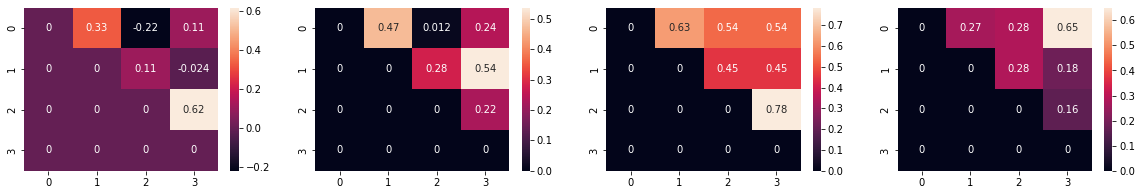

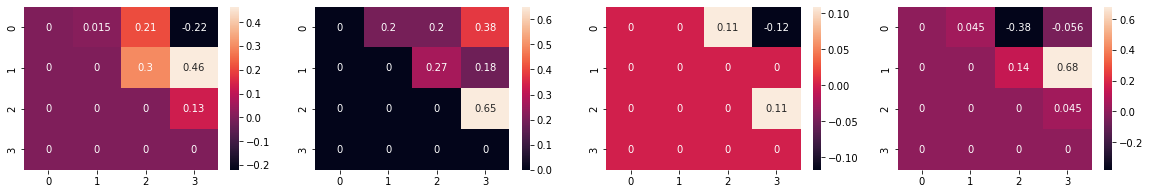

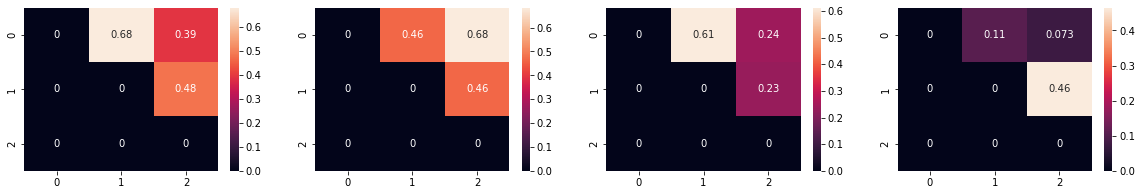

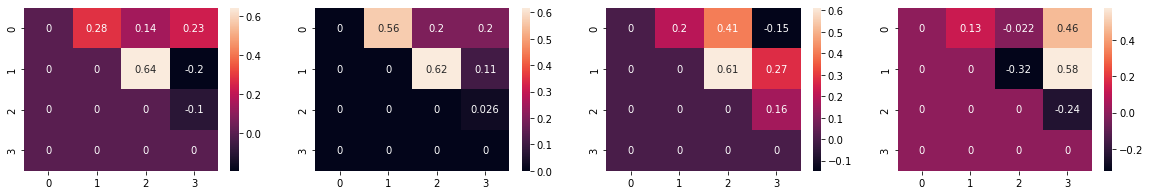

In [11]:
plot_cohen_kappa(pretrain_7b_all_cohens)
plot_cohen_kappa(finetune_7b_all_cohens)
plot_cohen_kappa(pretrain_65b_all_cohens)
plot_cohen_kappa(finetune_65b_all_cohens)